In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import time
import scipy.sparse
if (os.getcwd().endswith("notebooks")):
    os.chdir("..")
sys.path.insert(0, os.path.abspath("tests/benchmark_scripts"))
print(os.getcwd())

/mnt/c/Users/Peter/Documents/GitHub/Willump-Simple


In [2]:
def toxic_train(y, X_list):
    X = scipy.sparse.hstack([*X_list], format="csr")
    model = LogisticRegression(C=0.1, solver='sag')
    model = model.fit(X, y)
    return model


def toxic_predict(model, X_list):
    X = scipy.sparse.hstack([*X_list], format="csr")
    if X.shape[0] == 0:
        return np.zeros(0, dtype=np.int64)
    else:
        return model.predict(X)


def toxic_confidence(model, X_list):
    X = scipy.sparse.hstack([*X_list], format="csr")
    if X.shape[0] == 0:
        return np.zeros(0, dtype=np.float64)
    else:
        return model.predict_proba(X)[:, 1]


def toxic_score(true_y, pred_y):
    return roc_auc_score(true_y, pred_y)

In [3]:
from willump.evaluation.willump_executor import willump_execute

cascades_dict = {}

def transform_data(data, vectorizer):
    return vectorizer.transform(data)

@willump_execute(train_function=toxic_train,
                 predict_function=toxic_predict,
                 confidence_function=toxic_confidence,
                 score_function=toxic_score,
                 train_cascades_params=cascades_dict)
def toxic_train_pipeline(input_x, input_y, word_vect, char_vect):
    word_features = transform_data(input_x, word_vect)
    char_features = transform_data(input_x, char_vect)
    return toxic_train(input_y, [word_features, char_features])

In [4]:
base_directory = "tests/test_resources/toxic_resources/"
df = pd.read_csv(base_directory + 'train.csv').fillna(' ')
y = df["toxic"]
X = df["comment_text"].values
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
word_vectorizer = TfidfVectorizer(
    lowercase=False,
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 1),
    encoding="ascii",
    decode_error="strict",
    max_features=10000)
word_vectorizer.fit(train_X)
char_vectorizer = TfidfVectorizer(
    lowercase=False,
    analyzer='char',
    ngram_range=(2, 6),
    encoding="ascii",
    decode_error="strict",
    max_features=50000)
char_vectorizer.fit(train_X)

TfidfVectorizer(analyzer='char', encoding='ascii', lowercase=False,
                max_features=50000, ngram_range=(2, 6))

In [5]:
toxic_train_pipeline(train_X, train_y, word_vectorizer, char_vectorizer)
model = toxic_train_pipeline(train_X, train_y, word_vectorizer, char_vectorizer)

Feature: char_features             Cost: 99.042 Importance:  0.178
Feature: word_features             Cost:  3.684 Importance:  0.130
Cutoff: 0.100000 Threshold: 0.900000 Expected Cost: 24.101649


In [6]:
def toxic_eval_pipeline(input_x, model, word_vect, char_vect):
    word_features = transform_data(input_x, word_vect)
    char_features = transform_data(input_x, char_vect)
    return toxic_predict(model, [word_features, char_features])

time_start = time.time()
preds = toxic_eval_pipeline(test_X, model, word_vectorizer, char_vectorizer)
unopt_time_elapsed = time.time() - time_start
print("Elapsed Time %fs" % unopt_time_elapsed)

print("ROC-AUC Score Score: %f" % toxic_score(preds, test_y))

Elapsed Time 28.091385s
ROC-AUC Score Score: 0.939213


In [7]:
@willump_execute(predict_function=toxic_predict,
                 confidence_function=toxic_confidence,
                 predict_cascades_params=cascades_dict)
def toxic_eval_pipeline_cascades(input_x, model, word_vect, char_vect):
    word_features = transform_data(input_x, word_vect)
    char_features = transform_data(input_x, char_vect)
    return toxic_predict(model, [word_features, char_features])

toxic_eval_pipeline_cascades(test_X[:1000], model, word_vectorizer, char_vectorizer)
toxic_eval_pipeline_cascades(test_X[:1000], model, word_vectorizer, char_vectorizer)
time_start = time.time()
preds = toxic_eval_pipeline_cascades(test_X, model, word_vectorizer, char_vectorizer)
cascades_time_elapsed = time.time() - time_start
print("Elapsed Time %fs" % unopt_time_elapsed)

print("ROC-AUC Score Score: %f" % toxic_score(preds, test_y))

Elapsed Time 28.091385s
ROC-AUC Score Score: 0.939138


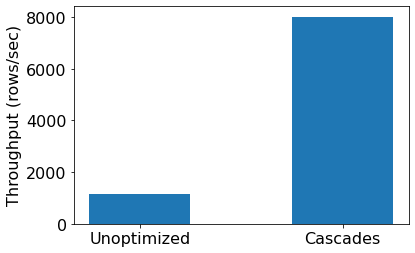

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
fig, axes = plt.subplots(figsize=(6, 4), ncols=1, nrows=1,
                         sharex=False, sharey=False)
x = np.arange(2)
width = 0.5  # the width of the bars
num_rows = len(test_X)

bars = axes.bar(x, [num_rows / unopt_time_elapsed, num_rows / cascades_time_elapsed], width)
axes.set(xlabel='', ylabel='Throughput (rows/sec)')
axes.set_xticks(x)
axes.set_xticklabels(["Unoptimized", "Cascades"])
plt.show()